# RNN

## Importing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df = pd.read_csv(file_path)
df

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_processed = df[['category', 'processed_tweets']]
df_processed = df_processed.rename(columns={'category': 'labels'})

# Limit to the first 50000 entries
df_processed = df_processed.iloc[:50000]
df_processed = df_processed.reset_index(drop=True)

# Separate df_processed by class
df_negative = df_processed[df_processed['labels'] == -1.0]
df_neutral = df_processed[df_processed['labels'] == 0.0]
df_positive = df_processed[df_processed['labels'] == 1.0]

# Find the number of samples in the minority class
min_samples = min(len(df_negative), len(df_neutral), len(df_positive))
print("min_samples ", min_samples)

# Resample other classes to match the minority class size
df_negative_balanced = df_negative.sample(n=min_samples, random_state=42)
df_neutral_balanced = df_neutral.sample(n=min_samples, random_state=42)
df_positive_balanced = df_positive.sample(n=min_samples, random_state=42)

# Concatenate the balanced datasets
df_balanced = pd.concat([df_negative_balanced, df_neutral_balanced, df_positive_balanced])

# Shuffle the balanced dataset
df_processed = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#ADDEDDDDDDDDDD
# After df_processed is balanced and before the split
df_processed['labels'] = df_processed['labels'].map({-1: 0, 0: 1, 1: 2})


# Now, proceed with splitting the balanced df_processed into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.25, random_state=42)

test_val_proportion = 0.15 / 0.25
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_val_proportion, random_state=42)

# Convert to lists for compatibility with further processing
X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

min_samples  11043


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from collections import Counter

# Preprocess the data: Remove NaN values and ensure tweets are strings
df_processed = df_processed.dropna(subset=['processed_tweets'])  # Drop rows where 'processed_tweets' is NaN
df_processed['processed_tweets'] = df_processed['processed_tweets'].astype(str)  # Ensure all tweets are strings

# Adjust labels from -1, 0, 1 to 0, 1, 2 for compatibility with nn.CrossEntropyLoss
#df_processed['labels'] = df_processed['labels'] + 1

# Tokenization and vocabulary creation
all_tokens = [token for tweet in df_processed['processed_tweets'] for token in tweet.split()]
token_freqs = Counter(all_tokens)

vocab = {token: idx+2 for idx, (token, _) in enumerate(token_freqs.items())}  # Start idx+2 to leave space for <PAD> and <UNK>

# Add <PAD> and <UNK> tokens to the vocabulary
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token, for words not in the vocabulary

class TwitterDataset(Dataset):
    def __init__(self, tweets, labels, vocab):
        self.tweets = tweets  # Ensure this is a list
        self.labels = labels  # Ensure this is a list
        self.vocab = vocab

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = str(self.tweets[idx])  # Convert to string to ensure compatibility with .split()
        # Use vocab.get to handle unknown tokens, defaults to '<UNK>' index if token is not found
        numericalized_tweet = [self.vocab.get(token, self.vocab['<UNK>']) for token in tweet.split()]
        return torch.tensor(numericalized_tweet, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Labels and tweets extraction
labels = df_processed['labels'].tolist()
tweets = df_processed['processed_tweets'].tolist()

dataset = TwitterDataset(tweets, labels, vocab)

def pad_collate_fn(batch):
    batch_tweets, batch_labels = zip(*batch)
    max_len = max(len(tweet) for tweet in batch_tweets)

    padded_tweets = [torch.cat((tweet, torch.full((max_len - len(tweet),), vocab['<PAD>'], dtype=torch.long))) for tweet in batch_tweets]
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)

    return torch.stack(padded_tweets), batch_labels


# Create datasets
train_dataset = TwitterDataset(X_train, y_train, vocab)
val_dataset = TwitterDataset(X_val, y_val, vocab)
test_dataset = TwitterDataset(X_test, y_test, vocab)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)


<ipython-input-13-63839211a468>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['processed_tweets'] = df_processed['processed_tweets'].astype(str)  # Ensure all tweets are strings


## Coding the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return F.log_softmax(output, dim=1), hidden  # Ensure log_softmax is applied correctly

## Training

In [ ]:
# # Section Six: Training Function
# def calculate_accuracy(y_pred, y):
#     _, predicted = torch.max(y_pred, 1)
#     correct = (predicted == y).float()  # Direct comparison without label adjustment
#     acc = correct.sum() / len(correct)
#     return acc


# def train(model, iterator, optimizer, loss_fn):
#     model.train()
#     epoch_loss, epoch_acc = 0, 0

#     for batch in iterator:
#         tweets, labels = batch
#         labels = labels.long()  # Ensure labels are long if they're not already, no additional +1 adjustment
#         optimizer.zero_grad()
#         predictions, hidden = model(tweets)
#         loss = loss_fn(predictions, labels)
#         acc = calculate_accuracy(predictions, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         epoch_acc += acc.item()

#     return epoch_loss / len(iterator), epoch_acc / len(iterator)

# def evaluate(model, iterator, loss_fn):
#     model.eval()
#     epoch_loss, epoch_acc = 0, 0

#     with torch.no_grad():
#         for batch in iterator:
#             tweets, labels = batch
#             labels = labels.long()  # Correctly ensure labels are integers, without +1 adjustment
#             predictions, hidden = model(tweets)
#             loss = loss_fn(predictions, labels)
#             acc = calculate_accuracy(predictions, labels)
#             epoch_loss += loss.item()
#             epoch_acc += acc.item()

#     return epoch_loss / len(iterator), epoch_acc / len(iterator), hidden


In [ ]:
# adjusted according to dataset and experimentations
vocab_size = len(vocab)  # Example value, adjust to your dataset's vocabulary size
embedding_dim = 100
hidden_dim = 256
output_dim = 3  # Output classes: -1, 0, 1 for negative, neutral, positive sentiments
dropout = 0.6

model = SentimentLSTM(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=3, dropout=dropout)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0002) #5e-4


Epoch 1/3 - Training Loss: 0.6610, Training Accuracy: 0.7359, Training F1: 0.7993, Validation Loss: 0.5423, Validation Accuracy: 0.7999, Validation F1: 0.7963
Epoch 2/3 - Training Loss: 0.5716, Training Accuracy: 0.7807, Training F1: 0.8403, Validation Loss: 0.4673, Validation Accuracy: 0.8363, Validation F1: 0.8347
Epoch 3/3 - Training Loss: 0.5010, Training Accuracy: 0.8165, Training F1: 0.8550, Validation Loss: 0.4435, Validation Accuracy: 0.8480, Validation F1: 0.8465


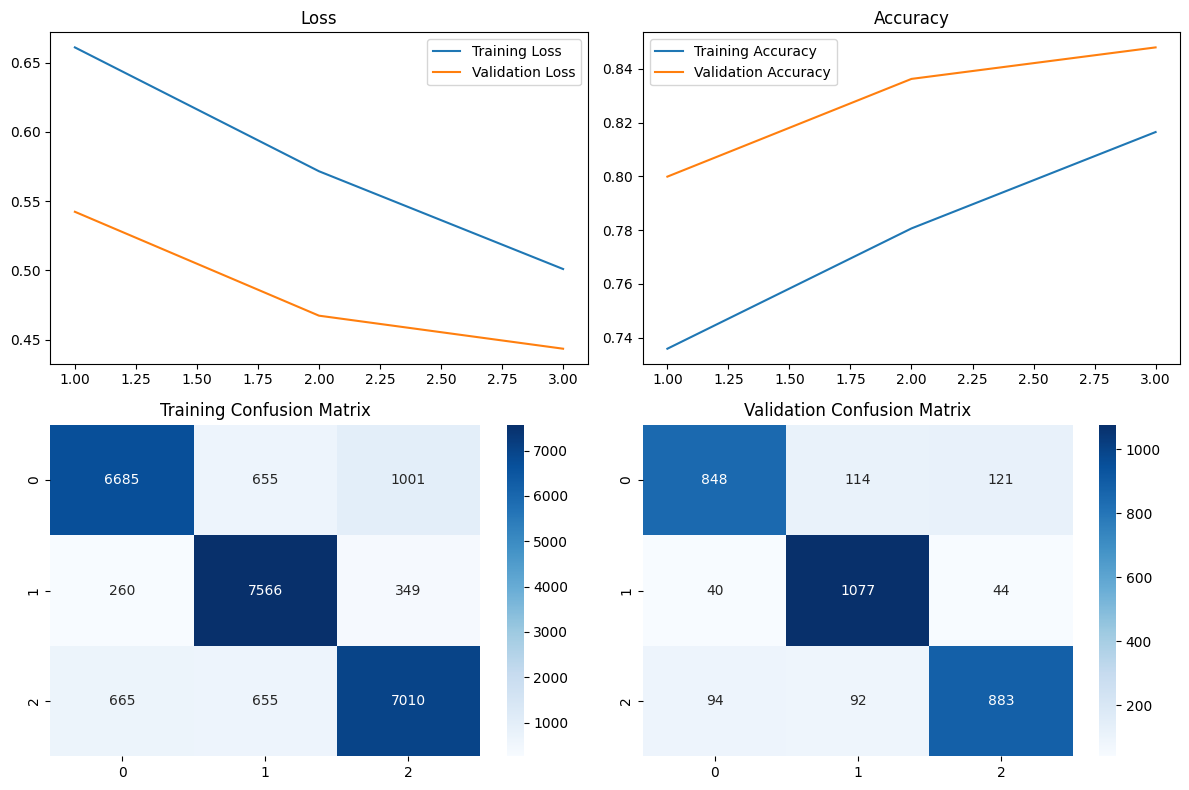

In [ ]:
# from sklearn.metrics import confusion_matrix, f1_score
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F
# #########
# # Check if CUDA (GPU support) is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ###########

# # Define the number of epochs
# num_epochs = 3  # Adjust based on previous advice
# patience = 8  # Patience for early stopping

# # Initialize variables for early stopping
# best_val_loss = float('inf')
# patience_counter = 0
# # Function to calculate metrics
# def calculate_metrics(model, data_loader):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs, h = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#     f1 = f1_score(all_labels, all_preds, average='weighted')
#     conf_matrix = confusion_matrix(all_labels, all_preds)
#     return f1, conf_matrix

# # Initialize metrics storage
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []
# train_f1_scores, val_f1_scores = [], []
# train_conf_matrices, val_conf_matrices = [], []

# # Training loop with metrics calculation
# for epoch in range(num_epochs):
#     train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
#     val_loss, val_acc, hidden = evaluate(model, val_loader, loss_fn)

#     train_f1, train_conf_matrix = calculate_metrics(model, train_loader)
#     val_f1, val_conf_matrix = calculate_metrics(model, val_loader)

#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)
#     train_f1_scores.append(train_f1)
#     val_f1_scores.append(val_f1)
#     train_conf_matrices.append(train_conf_matrix)
#     val_conf_matrices.append(val_conf_matrix)

#     print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}')

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#     else:
#         patience_counter += 1
#     if patience_counter >= patience:
#         print("Early stopping triggered.")
#         break

# # Plot loss and accuracy
# epochs_range = range(1, epoch + 2)  # Adjust range to number of epochs actually completed

# plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
# plt.plot(epochs_range, train_losses, label='Training Loss')
# plt.plot(epochs_range, val_losses, label='Validation Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
# plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
# plt.title('Accuracy')
# plt.legend()

# # Plot last epoch's confusion matrix for training and validation
# plt.subplot(2, 2, 3)
# sns.heatmap(train_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
# plt.title('Training Confusion Matrix')

# plt.subplot(2, 2, 4)
# sns.heatmap(val_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
# plt.title('Validation Confusion Matrix')

# plt.tight_layout()
# plt.show()


## Importing the RNN model

In [ ]:
len(val_loader)

104

In [ ]:
# Initialize the model
model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout)
model = model.to('cuda')

# Load the saved state_dict
model.load_state_dict(torch.load('drive/MyDrive/APS360 Group/Data preprocessing/best_model.pth'))

# Put the model in evaluation mode
model.eval()

# Run the model forward pass on some input data to get the last hidden state
hidden_states = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to('cuda')
        # Run the forward pass and collect the hidden states
        _, hidden = model(inputs)
        hidden_states.append(hidden.cpu().numpy())

# Now hidden_states contains the last hidden state for each input in the DataLoader


# CNN

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

# Define the feature extractor class
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(ResNetFeatureExtractor, self).__init__()
        # Extract all layers except the final fully connected layer from the pre-trained model
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features for the fully connected layer
        return x

# Initialize and modify the original ResNet model
resnet50 = models.resnet50(pretrained=False)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)  # Your specific output classes
)

# Load the state dictionary into the modified model
resnet50.load_state_dict(torch.load('/content/drive/My Drive/APS360 Group/Data preprocessing/Roza CNN Model Graphs/saved_model_80_accuracy.pth', map_location=torch.device('cpu')))

# Initialize the feature extractor with the loaded model
feature_extractor = ResNetFeatureExtractor(resnet50)

# Set to evaluation mode
feature_extractor.eval()

# Move the feature extractor to the appropriate device
feature_extractor = feature_extractor.to('cpu')

# Now you can use the feature_extractor to get the feature vectors


## Importing the data

In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from torchvision import transforms, datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((244, 244))
])


# Create an ImageFolder instance aka a dataloader
dataset = datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew', transform=transforms)

In [ ]:
batch_size = 32

# Shuffle and split the training set from the rest
np.random.seed(1000)
indices = list(range(len(dataset)))  # Generate indices for the entire dataset
np.random.shuffle(indices)
split_train = int(len(indices) * 0.8)  # 80-20 split
train_indices, test_val_indices = indices[:split_train], indices[split_train:]

# Shuffle and split the rest into testing and validation sets
np.random.shuffle(test_val_indices)
split_test_val = int(len(test_val_indices) * 0.95)  # 95-0.05 split
test_indices, val_indices = test_val_indices[:split_test_val], test_val_indices[split_test_val:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
# print("len train_loader ", len(train_loader))

val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
print("len val_loader ", len(val_loader))

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)
print("len test_loader ", len(test_loader))

len val_loader  14
len test_loader  257


In [ ]:
all_features = []
with torch.no_grad():  # Ensure no gradients are calculated
    for images, labels in val_loader:  # Assuming your DataLoader yields images and labels
        images = images.to(device)
        features = feature_extractor(images)
        all_features.append(features.cpu())  # Move features to CPU and store

# Trainable weight

## Checking the dim of the RNN hidden state

In [ ]:
len(hidden_states)

104

In [ ]:
len(hidden_states[0])

32

In [ ]:
for idx, hidden_state in enumerate(hidden_states):
    print(f"Batch {idx} hidden state shape: {hidden_state.shape}")


Batch 0 hidden state shape: (32, 256)
Batch 1 hidden state shape: (32, 256)
Batch 2 hidden state shape: (32, 256)
Batch 3 hidden state shape: (32, 256)
Batch 4 hidden state shape: (32, 256)
Batch 5 hidden state shape: (32, 256)
Batch 6 hidden state shape: (32, 256)
Batch 7 hidden state shape: (32, 256)
Batch 8 hidden state shape: (32, 256)
Batch 9 hidden state shape: (32, 256)
Batch 10 hidden state shape: (32, 256)
Batch 11 hidden state shape: (32, 256)
Batch 12 hidden state shape: (32, 256)
Batch 13 hidden state shape: (32, 256)
Batch 14 hidden state shape: (32, 256)
Batch 15 hidden state shape: (32, 256)
Batch 16 hidden state shape: (32, 256)
Batch 17 hidden state shape: (32, 256)
Batch 18 hidden state shape: (32, 256)
Batch 19 hidden state shape: (32, 256)
Batch 20 hidden state shape: (32, 256)
Batch 21 hidden state shape: (32, 256)
Batch 22 hidden state shape: (32, 256)
Batch 23 hidden state shape: (32, 256)
Batch 24 hidden state shape: (32, 256)
Batch 25 hidden state shape: (32, 2

## Checking the dim of the CNN hidden state

In [ ]:
len(all_features)

14

In [ ]:
# After the loop that appends to all_features
for idx, feature in enumerate(all_features):
    print(f"Feature batch {idx} shape: {feature.shape}")


Feature batch 0 shape: torch.Size([32, 2048])
Feature batch 1 shape: torch.Size([32, 2048])
Feature batch 2 shape: torch.Size([32, 2048])
Feature batch 3 shape: torch.Size([32, 2048])
Feature batch 4 shape: torch.Size([32, 2048])
Feature batch 5 shape: torch.Size([32, 2048])
Feature batch 6 shape: torch.Size([32, 2048])
Feature batch 7 shape: torch.Size([32, 2048])
Feature batch 8 shape: torch.Size([32, 2048])
Feature batch 9 shape: torch.Size([32, 2048])
Feature batch 10 shape: torch.Size([32, 2048])
Feature batch 11 shape: torch.Size([32, 2048])
Feature batch 12 shape: torch.Size([32, 2048])
Feature batch 13 shape: torch.Size([16, 2048])


## Passing in data to the trainable weight

### Inference on pretrained RNN model **has df columns with predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
# ''' twitter data'''
# import pandas as pd
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# from datasets import Dataset
# import torch
# import numpy as np

# # Load the tokenizer
# model_name = "cardiffnlp/twitter-roberta-base-sentiment"
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Prepare your dataset (repeat preprocessing steps as in training)
# file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
# df = pd.read_csv(file_path)
# df = df.dropna(subset=['processed_tweets'])
# df['processed_tweets'] = df['processed_tweets'].astype(str)
# df = df.iloc[:10]  # Adjust this to match your original dataset size if needed
# df['labels'] = df['category'].map({-1.0: 0, 0.0: 1, 1.0: 2})
# df

,clean_text,category,processed_tweets,labels
0,when modi promised “minimum government maximum...,-1.0,"when modi promise "" minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,1.0,what do just say vote for modi welcome bjp tel...,2
3,asking his supporters prefix chowkidar their n...,1.0,ask his supporter prefix chowkidar their name ...,2
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...,2
5,kiya tho refresh maarkefir comment karo,0.0,kiya tho refresh maarkefir comment karo,1
6,surat women perform yagna seeks divine grace f...,0.0,surat woman perform yagna seek divine grace fo...,1
7,this comes from cabinet which has scholars lik...,0.0,this come from cabinet which have scholar like...,1
8,with upcoming election india saga going import...,1.0,with upcoming election india saga go important...,2
9,gandhi was gay does modi,1.0,gandhi be gay do modi,2


In [ ]:
''' Flickr data'''
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset
import torch
import numpy as np

# Load the tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Prepare your dataset (repeat preprocessing steps as in training)
file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/image_descriptions_copy.csv'
df = pd.read_csv(file_path)
df = df.dropna(subset=['caption'])
df['processed_tweets'] = df['caption'].astype(str)
#df = df.iloc  # Adjust this to match your original dataset size if needed
df['labels'] = df['sentiment'].map({-1.0: 0, 0.0: 1, 1.0: 2})
df = df.drop(['caption', 'sentiment'], axis=1)
df

KeyboardInterrupt: 

In [ ]:
# ''' Test data'''
# import pandas as pd
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# from datasets import Dataset
# import torch
# import numpy as np

# # Load the tokenizer
# model_name = "cardiffnlp/twitter-roberta-base-sentiment"
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Prepare your dataset (repeat preprocessing steps as in training)
# file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Test data/LabelledCaptions.csv'
# df = pd.read_csv(file_path)
# df = df.dropna()
# df['processed_tweets'] = df['Caption'].astype(str)
# #df = df.iloc[:64]  # Adjust this to match your original dataset size if needed
# df['labels'] = df['Sentiment class'].map({-1.0: 0, 0.0: 1, 1.0: 2})
# df.drop(['Caption', 'Sentiment class'], axis=1, inplace=True)
# df

,ID,processed_tweets,labels
0,Charlotte1,all the neutrals,2
1,Charlotte2,2023 South Africa Player Awards!,2
2,Charlotte3,Bucket list summer hike in Mt. Rainier Nationa...,2
3,Charlotte4,Learning to danse under the rain,2
4,Charlotte5,study<<<take pics because the weather is nice,2
...,...,...,...
235,Zeina56,"Anxiety , it's not easy",0
236,Zeina57,I hate when people ignore the actual words tha...,0
237,Zeina58,It's Been Awhile And I Still Miss You.,0
238,Zeina59,𝘼𝙡𝙡 𝙩𝙝𝙚𝙨𝙚 𝙮𝙚𝙖𝙧𝙨 𝙡𝙖𝙩𝙚𝙧 𝙣𝙤𝙩𝙝𝙞𝙣𝙜 𝙘𝙝𝙖𝙣𝙜𝙚𝙙 𝙚𝙫𝙚𝙣 𝙩𝙝𝙤...,0


In [ ]:
dataset = Dataset.from_pandas(df)

def tokenize_function(examples):
    return tokenizer(examples["processed_tweets"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)

# Load the best model
best_model_path = 'drive/MyDrive/APS360 Group/Data preprocessing/best_model_additional_info_8000.pth'
model_checkpoint = torch.load(best_model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.load_state_dict(model_checkpoint['state_dict'])


import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming the setup is done (model loaded, dataset prepared)
# Your existing setup code goes here...

def predict(dataset, model, tokenizer):
    model.eval()  # Put model in evaluation mode
    predictions = []
    logits_list = []
    probabilities_list = []  # Store softmax probabilities here

    for example in dataset:
        # Tokenize and prepare inputs
        inputs = tokenizer(example['processed_tweets'], return_tensors="pt", padding=True, truncation=True, max_length=512)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1)  # Apply softmax to logits to get probabilities

            # Convert to NumPy arrays for storing in DataFrame
            logits_np = logits.cpu().numpy()
            probabilities_np = probabilities.cpu().numpy()

            logits_list.append(logits_np.squeeze())
            probabilities_list.append(probabilities_np.squeeze())  # Store probabilities

            predictions.append(logits.argmax(-1).item())

    matrix_np = np.array(logits_list)
    probabilities_np = np.array(probabilities_list)  # Convert list of probabilities to NumPy array

    # Convert the NumPy array to a PyTorch tensor
    matrix_tensor = torch.from_numpy(matrix_np)

    return predictions, matrix_tensor, probabilities_np

# Run inference
predictions, matrix_tensor, probabilities_np = predict(dataset, model, tokenizer)

# Attach predictions and predicted probabilities to the DataFrame for review
df['final_predicted_label_rnn'] = predictions
df['predicted_label_probabilities_rnn'] = list(probabilities_np)  # Convert each row of probabilities to a list and store in the DataFrame

# Calculate accuracy (existing part of your code)
accuracy = accuracy_score(df['labels'], df['final_predicted_label_rnn'])
print(f'Accuracy: {accuracy:.4f}')

# Example of printing out the first few rows of the DataFrame to see the new column
df


Map:   0%|          | 0/15018 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

KeyboardInterrupt: 

### Inference on CNN model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/ZeinaDataLabelsFlickrDataset.csv' #'drive/MyDrive/APS360 Group/Data preprocessing/Test data/TestSetPredictions.csv'

# Use read_csv to import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df = df.sample(frac=1).reset_index(drop=True)
df

,id,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
0,5277025928_f7cea9a79e,Enjoying the calm sea at Unawatuna unawatuna...,2,2,[8.1346807e-04 1.0106886e-03 9.9817586e-01],2,"[0.00022324307064991444, 0.010821681469678879,..."
1,2474913044_7c298bf5e4,Abandon Ship fenners norway may fjords msma...,0,1,[0.00119397 0.99671656 0.00208939],0,"[0.5693691968917847, 0.03132625296711922, 0.39..."
2,2067041147_0bcc898ffc,Amazing architecture in Nikko Japan a hrefhttp...,2,2,[8.2722737e-04 9.7813329e-04 9.9819463e-01],2,"[0.23502331972122192, 0.12818144261837006, 0.6..."
3,5661061601_5661126dd5,JACK THE RIPPER WOULD APPROVE MURDER BLOODY MU...,0,0,[0.90181553 0.06526098 0.03292349],0,"[0.9475405812263489, 0.050099167972803116, 0.0..."
4,4553009106_2002ed0035,Kid and Snickers this adorable girl at the dog...,2,2,[8.360039e-04 9.105134e-04 9.982535e-01],2,"[0.00019001409236807376, 0.0003499934100545943..."
...,...,...,...,...,...,...,...
15013,240759465_07f8890aa2,Bad Sign Were definitely not in Kansas anymore...,0,0,[0.9943878 0.00305258 0.00255963],0,"[0.8355535864830017, 0.16358020901679993, 0.00..."
15014,5065571080_8811b1871b,Village Underground Recycled tube train carria...,0,0,[0.6280181 0.3121849 0.05979708],0,"[0.43845751881599426, 0.2641880214214325, 0.29..."
15015,4395287498_ea347573d5,IMGJPG Dry wall of local bricks along the lime...,1,0,[0.9415625 0.03331228 0.02512525],1,"[0.08157532662153244, 0.9147007465362549, 0.00..."
15016,5636550850_358d79a6e1,K Run for Clean Air The Chevy table at the Ear...,1,2,[7.1435736e-04 1.2967670e-03 9.9798882e-01],1,"[0.21416544914245605, 0.5710201263427734, 0.21..."


In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
from torchvision import models
import os
from torch.utils.data import Subset
import random

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((244, 244)),
    transforms.Normalize(mean=[0.4509, 0.4269, 0.3913], std=[0.2789, 0.2737, 0.2865])
])

# Load dataset
dataset = datasets.ImageFolder(root='drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/SentimentClasses/SentimentClasses_filtered', transform=test_transforms)

# No need for train/test split if you're processing individually
N = len(dataset)  # Total number of items in the dataset

# Randomly sample 1000 unique indices from the dataset
random_indices = random.sample(range(N), 1000)

# Create a subset with the randomly sampled indices
test_data = Subset(dataset, random_indices)

print(dataset.class_to_idx)


# Load model
resnet50 = models.resnet50(pretrained=False)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)  # Assuming 3 output classes
)
resnet50 = resnet50.to(device)

# Load saved model weights
resnet50.load_state_dict(torch.load('/content/drive/My Drive/APS360 Group/Data preprocessing/saved_model_cnn_pretrained_old_data.pth', map_location=device))

# # Evaluate the model
# resnet50.eval()
# correct = 0
# total = 0

# # Iterate over individual images
# for idx in test_data.indices:  # Use indices to access each item
#     image, label = dataset[idx]  # Access items from the original dataset using indices
#     image_path, _ = dataset.imgs[idx]  # Get the file path for the current image
#     image_title = os.path.basename(image_path)  # Extract the file name from the path

#     # Print the image title
#     Id = image_title.split('.')[0]
#     print(f"Processing image: {Id}")

#     image = image.unsqueeze(0).to(device)  # Add batch dimension
#     label = torch.tensor([label]).to(device)

#     with torch.no_grad():
#         output = resnet50(image)
#         _, predicted = torch.max(output.data, 1)
#         total += 1
#         correct += (predicted == label).sum().item()

# # Calculate accuracy
# accuracy = correct / total
# print(f'Accuracy of the network on the test images: {accuracy * 100:.2f}%')


{'Negative_filtered': 0, 'Neutral_filtered': 1, 'Positive_filtered': 2}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
df

,id,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
0,5277025928_f7cea9a79e,Enjoying the calm sea at Unawatuna unawatuna...,2,2,[8.1346807e-04 1.0106886e-03 9.9817586e-01],2,"[0.00022324307064991444, 0.010821681469678879,..."
1,2474913044_7c298bf5e4,Abandon Ship fenners norway may fjords msma...,0,1,[0.00119397 0.99671656 0.00208939],0,"[0.5693691968917847, 0.03132625296711922, 0.39..."
2,2067041147_0bcc898ffc,Amazing architecture in Nikko Japan a hrefhttp...,2,2,[8.2722737e-04 9.7813329e-04 9.9819463e-01],2,"[0.23502331972122192, 0.12818144261837006, 0.6..."
3,5661061601_5661126dd5,JACK THE RIPPER WOULD APPROVE MURDER BLOODY MU...,0,0,[0.90181553 0.06526098 0.03292349],0,"[0.9475405812263489, 0.050099167972803116, 0.0..."
4,4553009106_2002ed0035,Kid and Snickers this adorable girl at the dog...,2,2,[8.360039e-04 9.105134e-04 9.982535e-01],2,"[0.00019001409236807376, 0.0003499934100545943..."
...,...,...,...,...,...,...,...
15013,240759465_07f8890aa2,Bad Sign Were definitely not in Kansas anymore...,0,0,[0.9943878 0.00305258 0.00255963],0,"[0.8355535864830017, 0.16358020901679993, 0.00..."
15014,5065571080_8811b1871b,Village Underground Recycled tube train carria...,0,0,[0.6280181 0.3121849 0.05979708],0,"[0.43845751881599426, 0.2641880214214325, 0.29..."
15015,4395287498_ea347573d5,IMGJPG Dry wall of local bricks along the lime...,1,0,[0.9415625 0.03331228 0.02512525],1,"[0.08157532662153244, 0.9147007465362549, 0.00..."
15016,5636550850_358d79a6e1,K Run for Clean Air The Chevy table at the Ear...,1,2,[7.1435736e-04 1.2967670e-03 9.9798882e-01],1,"[0.21416544914245605, 0.5710201263427734, 0.21..."


In [ ]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
from torchvision import models
import os
from torch.utils.data import Subset
import pandas as pd  # Assuming pandas is already imported

# Assuming df and other setup code are defined above...

# Initialize a dictionary to hold the id to prediction mapping
predictions_dict = {}
correct = 0
total = 0

print("test_data.indice", test_data)

# Evaluate the model and fill predictions_dict with image_id: predicted_class pairs
resnet50.eval()
p = 0
for idx in test_data.indices:
    print("p", p)
    p += 1
    image, label = dataset[idx]  # Load the image
    image_path, _ = dataset.imgs[idx]  # Get the image path
    image_id = os.path.basename(image_path).split('.')[0]  # Extract the image id (filename without extension)

    image = image.unsqueeze(0).to(device)  # Add batch dimension
    label = torch.tensor([label]).to(device)

    with torch.no_grad():
        output = resnet50(image)
        _, predicted = torch.max(output, 1)
        total += 1
        correct += (predicted == label).sum().item()

        predicted_class = predicted.cpu().item()
        predictions_dict[image_id] = predicted_class  # Map image_id to its predicted class


# Calculate accuracy
accuracy = correct / total
print(f'Accuracy of the network on the test images: {accuracy * 100:.2f}%')

# Assuming 'id' column in df contains image ids without file extension
# Map the predicted sentiment class to each id in the DataFrame
print("predictions_dict", predictions_dict)
df['final_predicted_label_cnn'] = df['id'].map(predictions_dict) # change the name of the ID column for the dataframe if needed

# Display the updated DataFrame
df

test_data.indice <torch.utils.data.dataset.Subset object at 0x78c450314b20>
p 0
p 1
p 2
p 3
p 4
p 5
p 6
p 7
p 8
p 9
p 10
p 11
p 12
p 13
p 14
p 15
p 16
p 17
p 18
p 19
p 20
p 21
p 22
p 23
p 24
p 25
p 26
p 27
p 28
p 29
p 30
p 31
p 32
p 33
p 34
p 35
p 36
p 37
p 38
p 39
p 40
p 41
p 42
p 43
p 44
p 45
p 46
p 47
p 48
p 49
p 50
p 51
p 52
p 53
p 54
p 55
p 56
p 57
p 58
p 59
p 60
p 61
p 62
p 63
p 64
p 65
p 66
p 67
p 68
p 69
p 70
p 71
p 72
p 73
p 74
p 75
p 76
p 77
p 78
p 79
p 80
p 81
p 82
p 83
p 84
p 85
p 86
p 87
p 88
p 89
p 90
p 91
p 92
p 93
p 94
p 95
p 96
p 97
p 98
p 99
p 100
p 101
p 102
p 103
p 104
p 105
p 106
p 107
p 108
p 109
p 110
p 111
p 112
p 113
p 114
p 115
p 116
p 117
p 118
p 119
p 120
p 121
p 122
p 123
p 124
p 125
p 126
p 127
p 128
p 129
p 130
p 131
p 132
p 133
p 134
p 135
p 136
p 137
p 138
p 139
p 140
p 141
p 142
p 143
p 144
p 145
p 146
p 147
p 148
p 149
p 150
p 151
p 152
p 153
p 154
p 155
p 156
p 157
p 158
p 159
p 160
p 161
p 162
p 163
p 164
p 165
p 166
p 167
p 168
p 169
p 170
p 171
p 

,id,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
0,5277025928_f7cea9a79e,Enjoying the calm sea at Unawatuna unawatuna...,2,2,[8.1346807e-04 1.0106886e-03 9.9817586e-01],NaN,"[0.00022324307064991444, 0.010821681469678879,..."
1,2474913044_7c298bf5e4,Abandon Ship fenners norway may fjords msma...,0,1,[0.00119397 0.99671656 0.00208939],NaN,"[0.5693691968917847, 0.03132625296711922, 0.39..."
2,2067041147_0bcc898ffc,Amazing architecture in Nikko Japan a hrefhttp...,2,2,[8.2722737e-04 9.7813329e-04 9.9819463e-01],NaN,"[0.23502331972122192, 0.12818144261837006, 0.6..."
3,5661061601_5661126dd5,JACK THE RIPPER WOULD APPROVE MURDER BLOODY MU...,0,0,[0.90181553 0.06526098 0.03292349],NaN,"[0.9475405812263489, 0.050099167972803116, 0.0..."
4,4553009106_2002ed0035,Kid and Snickers this adorable girl at the dog...,2,2,[8.360039e-04 9.105134e-04 9.982535e-01],NaN,"[0.00019001409236807376, 0.0003499934100545943..."
...,...,...,...,...,...,...,...
15013,240759465_07f8890aa2,Bad Sign Were definitely not in Kansas anymore...,0,0,[0.9943878 0.00305258 0.00255963],NaN,"[0.8355535864830017, 0.16358020901679993, 0.00..."
15014,5065571080_8811b1871b,Village Underground Recycled tube train carria...,0,0,[0.6280181 0.3121849 0.05979708],NaN,"[0.43845751881599426, 0.2641880214214325, 0.29..."
15015,4395287498_ea347573d5,IMGJPG Dry wall of local bricks along the lime...,1,0,[0.9415625 0.03331228 0.02512525],NaN,"[0.08157532662153244, 0.9147007465362549, 0.00..."
15016,5636550850_358d79a6e1,K Run for Clean Air The Chevy table at the Ear...,1,2,[7.1435736e-04 1.2967670e-03 9.9798882e-01],NaN,"[0.21416544914245605, 0.5710201263427734, 0.21..."


In [ ]:
df = df.dropna()
len(df[df['labels'] == 0])

342

In [ ]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
from torchvision import models
import os
from torch.utils.data import Subset
import pandas as pd
from torch.nn.functional import softmax

# Assuming df, device setup, and other initializations are defined above...

# Initialize dictionaries for mappings
predictions_dict = {}
probabilities_dict = {}

# Switch model to evaluation mode
resnet50.eval()

for idx in test_data.indices:
    # Load the image and get its path and ID
    image, _ = dataset[idx]
    image_path, _ = dataset.imgs[idx]
    image_id = os.path.basename(image_path).split('.')[0]

    # Process the image
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = resnet50(image)
        # Apply softmax to convert output logits to probabilities
        probabilities = softmax(output, dim=1)

        _, predicted = torch.max(output, 1)
        predicted_class = predicted.cpu().item()

        # Store predictions and probabilities
        predictions_dict[image_id] = predicted_class
        probabilities_dict[image_id] = probabilities.cpu().numpy().tolist()[0]  # Convert to list and store

# # Map the predicted class to each id in the DataFrame
# df['final_predicted_label_cnn'] = df['id'].map(predictions_dict)

# Map the probabilities to each id in the DataFrame
# Since the probabilities are stored as lists, use `apply` to handle them correctly
df['class_probabilities_cnn'] = df['id'].apply(lambda x: probabilities_dict.get(x, [None, None, None]))

# Display the updated DataFrame
df


,id,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
41,1294530859_0825b74ab2,So Sue Me The Cat Was Cute I was in the middle...,2,2,[9.0502785e-04 8.4365800e-04 9.9825126e-01],2.0,"[0.06939294189214706, 0.11737416684627533, 0.8..."
46,47474554_065c126bc1,Apple It fell from the tree and just lay there...,1,2,[0.00316759 0.00333286 0.99349964],2.0,"[0.2030099630355835, 0.17899774014949799, 0.61..."
71,7952673528_f685135544,Window Cooper School Window Cooper School a...,0,1,[0.0014836 0.9966371 0.00187936],1.0,"[0.24418099224567413, 0.6557502746582031, 0.10..."
83,3687985807_75ab01cbe2,Outdoor Game Airsofting at an quotundisclosed ...,0,0,[0.5435601 0.33689004 0.11954986],0.0,"[0.9337658882141113, 0.04824358597397804, 0.01..."
86,5400021815_ba70402335,Chernobyl Effect ba hrefhttpwwwursparkcomvobp...,0,2,[0.01036289 0.01957415 0.970063 ],1.0,"[0.20853284001350403, 0.7577738165855408, 0.03..."
...,...,...,...,...,...,...,...
14914,3783290153_e6b3d116b0,berlin architecture Berlin had some of the mos...,2,2,[9.3822525e-04 8.5030869e-04 9.9821150e-01],2.0,"[0.020298900082707405, 0.32946813106536865, 0...."
14980,4962811246_4437d9bedf,Calm seas It just blew my mind that this was N...,2,2,[8.7348296e-04 1.1945606e-03 9.9793196e-01],2.0,"[0.06886116415262222, 0.4191649258136749, 0.51..."
14985,2763736468_45895cb566,Tuyuti station Abandoned train station near Bu...,0,1,[0.00602004 0.98877037 0.00520969],2.0,"[0.1268567442893982, 0.3823511302471161, 0.490..."
15000,2361945706_a150b032e3,ingarden Page th September Two months have pas...,0,2,[0.00323362 0.0012151 0.99555135],2.0,"[0.018535902723670006, 0.07473708689212799, 0...."


In [ ]:
df.to_csv('drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/ZeinaDataLabelsFlickrDatasetShort_1000entries.csv', index=False)

### Getting stats on predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/ZeinaDataLabelsFlickrDatasetShort_1000entries.csv' #'drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/ZeinaDataLabelsFlickrDataset.csv' #'drive/MyDrive/APS360 Group/Data preprocessing/Test data/TestSetPredictions.csv'

# Use read_csv to import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df

,id,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
0,1294530859_0825b74ab2,So Sue Me The Cat Was Cute I was in the middle...,2,2,[9.0502785e-04 8.4365800e-04 9.9825126e-01],2.0,"[0.06939294189214706, 0.11737416684627533, 0.8..."
1,47474554_065c126bc1,Apple It fell from the tree and just lay there...,1,2,[0.00316759 0.00333286 0.99349964],2.0,"[0.2030099630355835, 0.17899774014949799, 0.61..."
2,7952673528_f685135544,Window Cooper School Window Cooper School a...,0,1,[0.0014836 0.9966371 0.00187936],1.0,"[0.24418099224567413, 0.6557502746582031, 0.10..."
3,3687985807_75ab01cbe2,Outdoor Game Airsofting at an quotundisclosed ...,0,0,[0.5435601 0.33689004 0.11954986],0.0,"[0.9337658882141113, 0.04824358597397804, 0.01..."
4,5400021815_ba70402335,Chernobyl Effect ba hrefhttpwwwursparkcomvobp...,0,2,[0.01036289 0.01957415 0.970063 ],1.0,"[0.20853284001350403, 0.7577738165855408, 0.03..."
...,...,...,...,...,...,...,...
996,3783290153_e6b3d116b0,berlin architecture Berlin had some of the mos...,2,2,[9.3822525e-04 8.5030869e-04 9.9821150e-01],2.0,"[0.020298900082707405, 0.32946813106536865, 0...."
997,4962811246_4437d9bedf,Calm seas It just blew my mind that this was N...,2,2,[8.7348296e-04 1.1945606e-03 9.9793196e-01],2.0,"[0.06886116415262222, 0.4191649258136749, 0.51..."
998,2763736468_45895cb566,Tuyuti station Abandoned train station near Bu...,0,1,[0.00602004 0.98877037 0.00520969],2.0,"[0.1268567442893982, 0.3823511302471161, 0.490..."
999,2361945706_a150b032e3,ingarden Page th September Two months have pas...,0,2,[0.00323362 0.0012151 0.99555135],2.0,"[0.018535902723670006, 0.07473708689212799, 0...."


In [ ]:
# Calculate the number of times `final_predicted_label_rnn` matches `labels`
rnn_agree = (df['final_predicted_label_rnn'] == df['labels']).sum()

# Calculate the number of times `final_predicted_label_cnn` matches `labels`
cnn_agree = (df['final_predicted_label_cnn'] == df['labels']).sum()

# Calculate the number of times both `final_predicted_label_rnn` and `final_predicted_label_cnn` agree with `labels`
all_agree = ((df['final_predicted_label_rnn'] == df['labels']) & (df['final_predicted_label_cnn'] == df['labels'])).sum()

print("The % of times the text model matches the labels", rnn_agree / len(df))
print("The % of times the image model matches the labels", cnn_agree / len(df))
print("The % of times the text & image models matches the labels", all_agree / len(df))


The % of times the text model matches the labels 0.5464535464535465
The % of times the image model matches the labels 0.38461538461538464
The % of times the text & image models matches the labels 0.24975024975024976


RNN Metrics:
Accuracy: 0.5464535464535465
Precision: 0.5352879762912479
Recall: 0.5464535464535465
F1 Score: 0.5050293959653617

CNN Metrics:
Accuracy: 0.38461538461538464
Precision: 0.39210079184210933
Recall: 0.38461538461538464
F1 Score: 0.3688587432009358


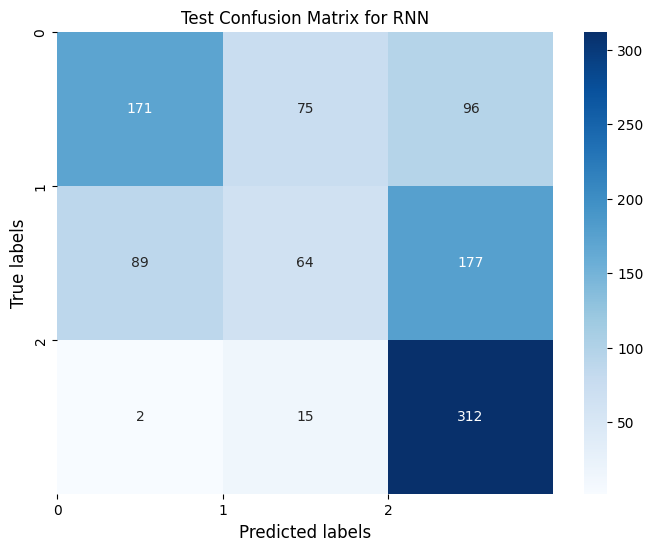

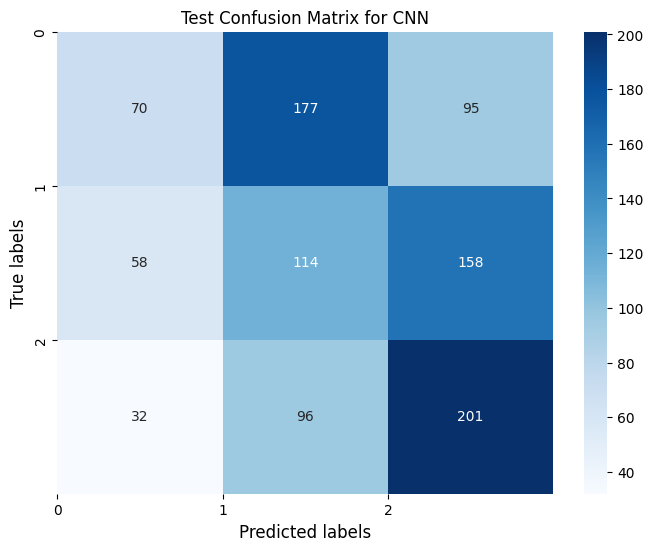

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your dataframe
# df = pd.read_csv('path_to_your_csv.csv')  # Replace with your CSV file path

# Define the labels of the classes
class_labels = [0, 1, 2]

# Compute metrics for RNN
accuracy_rnn = accuracy_score(df['labels'], df['final_predicted_label_rnn'])
precision_rnn, recall_rnn, f1_score_rnn, _ = precision_recall_fscore_support(df['labels'], df['final_predicted_label_rnn'], labels=class_labels, average='weighted')
conf_matrix_rnn = confusion_matrix(df['labels'], df['final_predicted_label_rnn'], labels=class_labels)

# Compute metrics for CNN
accuracy_cnn = accuracy_score(df['labels'], df['final_predicted_label_cnn'])
precision_cnn, recall_cnn, f1_score_cnn, _ = precision_recall_fscore_support(df['labels'], df['final_predicted_label_cnn'], labels=class_labels, average='weighted')
conf_matrix_cnn = confusion_matrix(df['labels'], df['final_predicted_label_cnn'], labels=class_labels)

# Print the metrics
print('RNN Metrics:')
print(f'Accuracy: {accuracy_rnn}')
print(f'Precision: {precision_rnn}')
print(f'Recall: {recall_rnn}')
print(f'F1 Score: {f1_score_rnn}')

print('\nCNN Metrics:')
print(f'Accuracy: {accuracy_cnn}')
print(f'Precision: {precision_cnn}')
print(f'Recall: {recall_cnn}')
print(f'F1 Score: {f1_score_cnn}')

# Function to plot confusion matrix like the image provided
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True labels',fontsize=12)
    plt.xlabel('Predicted labels',fontsize=12)
    plt.title(title,fontsize=12)
    plt.xticks(ticks=[0, 1, 2], labels=['0', '1', '2'])
    plt.yticks(ticks=[0, 1, 2], labels=['0', '1', '2'])
    plt.show()

# Plot confusion matrix for RNN
plot_confusion_matrix(conf_matrix_rnn, title='Test Confusion Matrix for RNN')

# Plot confusion matrix for CNN
plot_confusion_matrix(conf_matrix_cnn, title='Test Confusion Matrix for CNN')


### Weighted average training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/ZeinaDataLabelsFlickrDatasetShort_1000entries.csv'

# Use read_csv to import the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [3]:
len(df[df['labels'] == 2])

329

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming df["predicted_label_probabilities_rnn"] and df["class_probabilities_cnn"] are lists of lists,
# and you want to concatenate the probabilities from RNN and CNN for each instance
# This requires a bit of manipulation if they are indeed lists of probabilities as mentioned

# Simulating the concatenation of two lists of probabilities (for demonstration)
# In your case, you need to ensure X is correctly formed from your dataframe columns
X = np.random.rand(len(df), 6)  # Placeholder for concatenated probabilities

# Labels
y = np.array(df["labels"])

# One-hot encode the labels
Y = to_categorical(y, num_classes=3)

# Splitting the dataset into training plus validation, and test sets
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Splitting the temporary training plus validation set into separate training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(600, 6) (200, 6) (201, 6) (600, 3) (200, 3) (201, 3)


In [ ]:
# processed_X_train = []
# for string in X_train:
#     parts = string.replace('[', '').split(']')
#     parts_cleaned = [part for part in parts if part]
#     list1 = list(map(float, parts_cleaned[0].split()))
#     list2 = list(map(float, parts_cleaned[1].split(', ')))
#     processed_X_train.append(list1 + list2)

# # Convert to numpy array for machine learning processing
# X_train = np.array(processed_X_train)

# processed_X_val = []
# for string in X_val:
#     parts = string.replace('[', '').split(']')
#     parts_cleaned = [part for part in parts if part]
#     list1 = list(map(float, parts_cleaned[0].split()))
#     list2 = list(map(float, parts_cleaned[1].split(', ')))
#     processed_X_val.append(list1 + list2)

# # Convert to numpy array for machine learning processing
# X_val = np.array(processed_X_val)


In [ ]:
X_val.shape, X_train.shape, Y_train.shape, Y_val.shape

((200, 6), (600, 6), (600, 3), (200, 3))

Epoch 1/30
10/10 [==============================] - 2s 34ms/step - loss: 1.7744 - accuracy: 0.3117 - val_loss: 1.1253 - val_accuracy: 0.2850
Epoch 2/30
10/10 [==============================] - 0s 8ms/step - loss: 1.6823 - accuracy: 0.3167 - val_loss: 1.1222 - val_accuracy: 0.3000
Epoch 3/30
10/10 [==============================] - 0s 7ms/step - loss: 1.4736 - accuracy: 0.3667 - val_loss: 1.1186 - val_accuracy: 0.3050
Epoch 4/30
10/10 [==============================] - 0s 7ms/step - loss: 1.5173 - accuracy: 0.3400 - val_loss: 1.1160 - val_accuracy: 0.3100
Epoch 5/30
10/10 [==============================] - 0s 8ms/step - loss: 1.4370 - accuracy: 0.3517 - val_loss: 1.1151 - val_accuracy: 0.3350
Epoch 6/30
10/10 [==============================] - 0s 6ms/step - loss: 1.3903 - accuracy: 0.3467 - val_loss: 1.1152 - val_accuracy: 0.3350
Epoch 7/30
10/10 [==============================] - 0s 6ms/step - loss: 1.3872 - accuracy: 0.3667 - val_loss: 1.1156 - val_accuracy: 0.3450
Epoch 8/30
10/10 [=

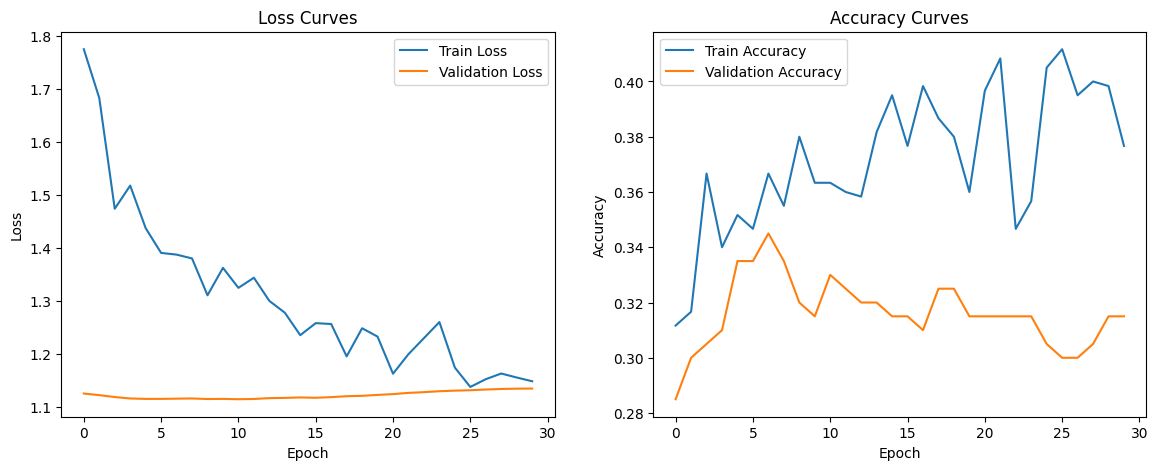

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Design the improved model
model = Sequential([
    Dense(64, activation='relu', input_shape=(6,), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),  # Normalization after activation can sometimes be more effective
    Dropout(0.3),  # Reduced dropout rate to retain more information
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),  # Added another Dense layer with BatchNormalization
    Dropout(0.3),  # Consistent dropout rate for the additional layer
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=64) #, callbacks=[early_stopping])

import matplotlib.pyplot as plt

# Assuming 'history' is the output from the fit operation
# and contains the training history metrics

# Plot the loss curves
plt.figure(figsize=(14, 5))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# You can now use model.predict() to make predictions on new data.

7/7 [==============================] - 0s 2ms/step


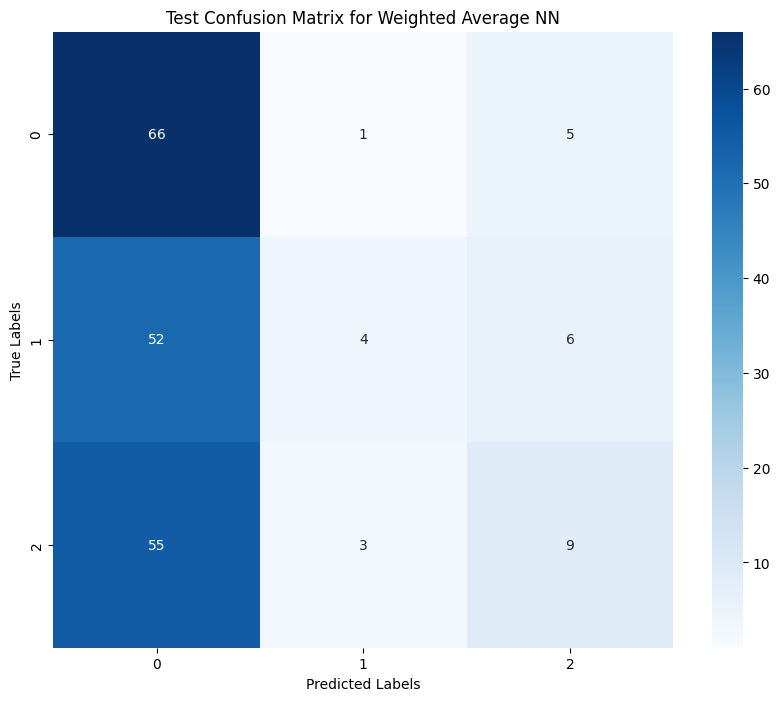

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions on the test set
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(Y_test, axis=1)

# Generate the confusion matrix using test data
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Test Confusion Matrix for Weighted Average NN')
plt.show()


### Weighted average testing


In [10]:
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Test data/TestSetPredictions.csv'

# Use read_csv to import the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [11]:
df

,ID,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
0,Charlotte1,all the neutrals,2,1,[0.00112956 0.99719965 0.00167082],2.0,"[0.0023047958966344595, 0.020311053842306137, ..."
1,Charlotte2,2023 South Africa Player Awards!,2,1,[6.2006485e-04 9.9668425e-01 2.6956387e-03],0.0,"[0.4687722325325012, 0.258206307888031, 0.2730..."
2,Charlotte3,Bucket list summer hike in Mt. Rainier Nationa...,2,2,[9.3335134e-04 8.8120811e-04 9.9818546e-01],2.0,"[0.0007622151752002537, 0.009342552162706852, ..."
3,Charlotte4,Learning to danse under the rain,2,1,[0.00151704 0.9944733 0.00400956],2.0,"[0.005608619190752506, 0.004354978445917368, 0..."
4,Charlotte5,study<<<take pics because the weather is nice,2,2,[7.6025707e-04 9.3734963e-04 9.9830234e-01],2.0,"[0.22243386507034302, 0.14625322818756104, 0.6..."
...,...,...,...,...,...,...,...
232,Zeina56,"Anxiety , it's not easy",0,0,[0.9919694 0.00450624 0.00352433],0.0,"[0.9571062922477722, 0.04142903909087181, 0.00..."
233,Zeina57,I hate when people ignore the actual words tha...,0,0,[0.99475765 0.00283127 0.00241102],0.0,"[0.7338071465492249, 0.010038355365395546, 0.2..."
234,Zeina58,It's Been Awhile And I Still Miss You.,0,0,[0.86079717 0.13342407 0.00577882],2.0,"[0.19259332120418549, 0.009840348735451698, 0...."
235,Zeina59,𝘼𝙡𝙡 𝙩𝙝𝙚𝙨𝙚 𝙮𝙚𝙖𝙧𝙨 𝙡𝙖𝙩𝙚𝙧 𝙣𝙤𝙩𝙝𝙞𝙣𝙜 𝙘𝙝𝙖𝙣𝙜𝙚𝙙 𝙚𝙫𝙚𝙣 𝙩𝙝𝙤...,0,1,[0.0039818 0.99032134 0.00569693],1.0,"[0.08031944185495377, 0.910815417766571, 0.008..."


In [12]:
# df = df[~df['ID'].str.contains('Rollis')]
# df

In [13]:
# df[df['ID'] == 'Zeina35']

In [14]:
# Prepare data
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Convert lists of probabilities into numpy arrays
X = np.array(df["predicted_label_probabilities_rnn"] + df["class_probabilities_cnn"])

# Labels
y = np.array(df["labels"])

# One-hot encode the labels
Y = to_categorical(y, num_classes=3)

X_test = X
Y_test = Y

X_test.shape, Y_test.shape

((237,), (237, 3))

In [15]:
X_test[54]

'[0.9911618  0.00517155 0.00366663][0.9433643221855164, 0.034129511564970016, 0.02250620536506176]'

In [16]:
Y_test[54]

array([1., 0., 0.], dtype=float32)

In [17]:
X_test[17]

'[0.00105087 0.0238532  0.9750959 ][0.03211210295557976, 0.27079063653945923, 0.6970973014831543]'

In [18]:
Y_test[17]

array([0., 0., 1.], dtype=float32)

In [19]:
processed_X_train = []
i = -1
for string in X_test:
    i += 1
    parts = string.replace('[', '').split(']')
    parts_cleaned = [part for part in parts if part]
    if (parts_cleaned[0].split()[0] == 'None') or (parts_cleaned[1].split(', ')[0] == 'None'):
        print("i", i)
        print("Y_test", Y_test[i])
        Y_test = np.delete(Y_test, i, axis=0)
    else:
      list1 = list(map(float, parts_cleaned[0].split()))
      list2 = list(map(float, parts_cleaned[1].split(', ')))
      processed_X_train.append(list1 + list2)


# Convert to numpy array for machine learning processing
X_test = np.array(processed_X_train)

X_test.shape, Y_test.shape

((237, 6), (237, 3))

8/8 [==============================] - 0s 4ms/step
Accuracy: 0.3080168776371308
Recall: 0.3080168776371308
Precision: 0.30898816373499915
F1 Score: 0.3084653867380995
Confusion Matrix:
[[31 11 37]
 [31 23 24]
 [15 46 19]]


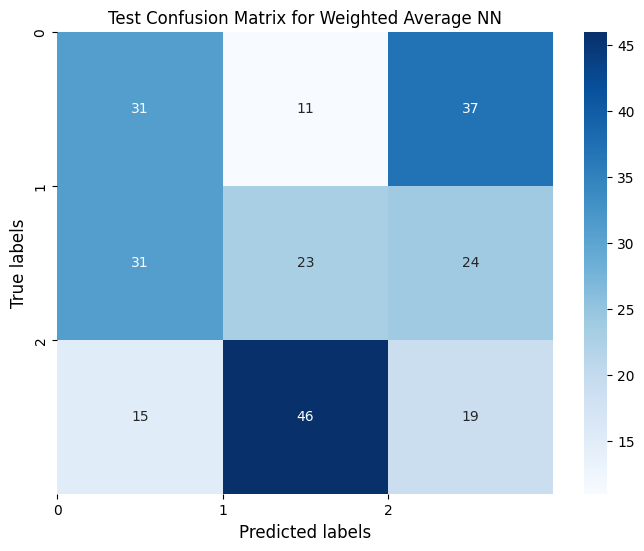

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns

y_test = Y_test

# Predict the probabilities for the test set
predictions_proba = model.predict(X_test)

# Convert probabilities to predicted class labels
predicted_classes = np.argmax(predictions_proba, axis=1)

y_test_numerical = np.argmax(y_test, axis=1)

# Now, calculate the metrics using y_test_numerical
accuracy = accuracy_score(y_test_numerical, predicted_classes)
recall = recall_score(y_test_numerical, predicted_classes, average='weighted')
precision = precision_score(y_test_numerical, predicted_classes, average='weighted')
f1 = f1_score(y_test_numerical, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(y_test_numerical, predicted_classes)

# Print the metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Function to plot confusion matrix like the image provided
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True labels',fontsize=12)
    plt.xlabel('Predicted labels',fontsize=12)
    plt.title(title,fontsize=12)
    plt.xticks(ticks=[0, 1, 2], labels=['0', '1', '2'])
    plt.yticks(ticks=[0, 1, 2], labels=['0', '1', '2'])
    plt.show()

# Plot confusion matrix for
plot_confusion_matrix(conf_matrix, title='Test Confusion Matrix for Weighted Average NN')

In [21]:
X_test.shape

(237, 6)

In [ ]:
df

,ID,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
0,Charlotte1,all the neutrals,2,1,[0.00112956 0.99719965 0.00167082],2.0,"[0.0023047958966344595, 0.020311053842306137, ..."
1,Charlotte2,2023 South Africa Player Awards!,2,1,[6.2006485e-04 9.9668425e-01 2.6956387e-03],0.0,"[0.4687722325325012, 0.258206307888031, 0.2730..."
2,Charlotte3,Bucket list summer hike in Mt. Rainier Nationa...,2,2,[9.3335134e-04 8.8120811e-04 9.9818546e-01],2.0,"[0.0007622151752002537, 0.009342552162706852, ..."
3,Charlotte4,Learning to danse under the rain,2,1,[0.00151704 0.9944733 0.00400956],2.0,"[0.005608619190752506, 0.004354978445917368, 0..."
4,Charlotte5,study<<<take pics because the weather is nice,2,2,[7.6025707e-04 9.3734963e-04 9.9830234e-01],2.0,"[0.22243386507034302, 0.14625322818756104, 0.6..."
...,...,...,...,...,...,...,...
232,Zeina56,"Anxiety , it's not easy",0,0,[0.9919694 0.00450624 0.00352433],0.0,"[0.9571062922477722, 0.04142903909087181, 0.00..."
233,Zeina57,I hate when people ignore the actual words tha...,0,0,[0.99475765 0.00283127 0.00241102],0.0,"[0.7338071465492249, 0.010038355365395546, 0.2..."
234,Zeina58,It's Been Awhile And I Still Miss You.,0,0,[0.86079717 0.13342407 0.00577882],2.0,"[0.19259332120418549, 0.009840348735451698, 0...."
235,Zeina59,𝘼𝙡𝙡 𝙩𝙝𝙚𝙨𝙚 𝙮𝙚𝙖𝙧𝙨 𝙡𝙖𝙩𝙚𝙧 𝙣𝙤𝙩𝙝𝙞𝙣𝙜 𝙘𝙝𝙖𝙣𝙜𝙚𝙙 𝙚𝙫𝙚𝙣 𝙩𝙝𝙤...,0,1,[0.0039818 0.99032134 0.00569693],1.0,"[0.08031944185495377, 0.910815417766571, 0.008..."


### Section for the quantitative results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/ZeinaDataLabelsFlickrDatasetShort_1000entries.csv' #'drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/ZeinaDataLabelsFlickrDataset.csv' #'drive/MyDrive/APS360 Group/Data preprocessing/Test data/TestSetPredictions.csv'

# Use read_csv to import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df

,id,processed_tweets,labels,final_predicted_label_rnn,predicted_label_probabilities_rnn,final_predicted_label_cnn,class_probabilities_cnn
0,1294530859_0825b74ab2,So Sue Me The Cat Was Cute I was in the middle...,2,2,[9.0502785e-04 8.4365800e-04 9.9825126e-01],2.0,"[0.06939294189214706, 0.11737416684627533, 0.8..."
1,47474554_065c126bc1,Apple It fell from the tree and just lay there...,1,2,[0.00316759 0.00333286 0.99349964],2.0,"[0.2030099630355835, 0.17899774014949799, 0.61..."
2,7952673528_f685135544,Window Cooper School Window Cooper School a...,0,1,[0.0014836 0.9966371 0.00187936],1.0,"[0.24418099224567413, 0.6557502746582031, 0.10..."
3,3687985807_75ab01cbe2,Outdoor Game Airsofting at an quotundisclosed ...,0,0,[0.5435601 0.33689004 0.11954986],0.0,"[0.9337658882141113, 0.04824358597397804, 0.01..."
4,5400021815_ba70402335,Chernobyl Effect ba hrefhttpwwwursparkcomvobp...,0,2,[0.01036289 0.01957415 0.970063 ],1.0,"[0.20853284001350403, 0.7577738165855408, 0.03..."
...,...,...,...,...,...,...,...
996,3783290153_e6b3d116b0,berlin architecture Berlin had some of the mos...,2,2,[9.3822525e-04 8.5030869e-04 9.9821150e-01],2.0,"[0.020298900082707405, 0.32946813106536865, 0...."
997,4962811246_4437d9bedf,Calm seas It just blew my mind that this was N...,2,2,[8.7348296e-04 1.1945606e-03 9.9793196e-01],2.0,"[0.06886116415262222, 0.4191649258136749, 0.51..."
998,2763736468_45895cb566,Tuyuti station Abandoned train station near Bu...,0,1,[0.00602004 0.98877037 0.00520969],2.0,"[0.1268567442893982, 0.3823511302471161, 0.490..."
999,2361945706_a150b032e3,ingarden Page th September Two months have pas...,0,2,[0.00323362 0.0012151 0.99555135],2.0,"[0.018535902723670006, 0.07473708689212799, 0...."


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import glob

# Assuming df is your pandas dataframe
# ...

# Base directory where the images are stored
base_image_directory = "drive/MyDrive/APS360 Group/Data preprocessing/ImagesZeina/SentimentClasses/SentimentClasses_filtered"

# Identify misclassified images by the CNN
misclassified = df[df['labels'] != df['final_predicted_label_cnn']]

# Define a function to display an image with a caption
def show_image(image_path, caption, rnn_prediction, cnn_prediction, actual_label):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Caption: {caption}\nRNN Predicted: {rnn_prediction}, CNN Predicted: {cnn_prediction}, Actual: {actual_label}")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Set the number of images to display
num_images_to_display = 50

# Iterate through the misclassified dataframe and display images
for index, row in misclassified.iterrows():
    if num_images_to_display <= 0:
        break  # Break the loop if we've displayed the desired number of images

    image_id = row['id']
    caption = row['processed_tweets']
    actual_label = row['labels']
    rnn_prediction = row['final_predicted_label_rnn']
    cnn_prediction = row['final_predicted_label_cnn']
    rnn_prediction_prob = row['predicted_label_probabilities_rnn']
    cnn_prediction_prob = row['class_probabilities_cnn']

    file_pattern = os.path.join(base_image_directory, '**', image_id + '.*')
    matching_files = glob.glob(file_pattern, recursive=True)

    # If we find matching files, display the image
    if matching_files:
        print(f"Displaying image for ID: {image_id}")
        print(f"Caption: {caption}")
        print(f"RNN Predicted: {rnn_prediction}, RNN prob: {rnn_prediction_prob}, CNN Predicted: {cnn_prediction}, CNN prob: {cnn_prediction_prob}, Actual: {actual_label}")
        show_image(matching_files[0], caption, rnn_prediction, cnn_prediction, actual_label)
        num_images_to_display -= 1  # Decrement the counter
    else:
        print(f"No image found for ID: {image_id}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
condition = (df['labels'] == 0) & (df['final_predicted_label_rnn'] == 0) & (df['final_predicted_label_cnn'] != 0)
filtered_df = df[condition]

num_correct_rnn_wrong_cnn = filtered_df.shape[0]
total_negative = (df['labels'] == 0).sum()
proportion_correct_rnn_wrong_cnn = num_correct_rnn_wrong_cnn / total_negative if total_negative else 0

num_correct_rnn_wrong_cnn, proportion_correct_rnn_wrong_cnn

(452, 0.452)

In [ ]:
condition = (df['labels'] == 0) & (df['final_predicted_label_rnn'] == 0) & (df['final_predicted_label_cnn'] != 0)
filtered_df = df[condition]

num_correct_rnn_wrong_cnn = filtered_df.shape[0]
total_negative = (df['labels'] == 0).sum()
proportion_correct_rnn_wrong_cnn = num_correct_rnn_wrong_cnn / total_negative if total_negative else 0

num_correct_rnn_wrong_cnn, proportion_correct_rnn_wrong_cnn

(131, 0.3830409356725146)

### Stats on the test data

In [ ]:
avg_char_length = df.groupby('labels')['processed_tweets'].apply(lambda x: x.str.len().mean())

print(avg_char_length)

labels
0    427.983051
1    173.068966
2    200.166667
Name: processed_tweets, dtype: float64
